In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from unsupervised_bias_detection.cluster import BiasAwareHierarchicalKMeans

#### A. Load data and data preparation

##### A.1 Load data

In [2]:
# Load the COMPAS dataset
file_path = "./FP-test-set.csv"
df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataset
df.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP
0,84,2,0,1,1,1828600,102.622934,-0.4767,0
1,93,1,0,0,1,45988032,82.510668,0.0000,0
2,89,1,0,0,1,16023476,155.112226,0.0000,0
3,80,1,0,0,1,3629813,601.280035,-0.6486,0
4,87,0,0,0,0,3479057,253.795131,0.0000,0


##### A.2 Data cleaning

In [3]:
# Check for missing values
print(df.isnull().sum())

length             0
#URLs              0
#mentions          0
#hashs             0
verified           0
#followers         0
user_engagement    0
sentiment_score    0
FP                 0
dtype: int64


**UI text #1** (only demo)

**Information about demo dataset**

...


**UI text #2**

In this example, we analyze which group is most adversely affected by the risk prediction algorithm. We do this by applying the clustering algorithm on the dataset previewed below. A preview of the data can be found below. The column `false_positive` is used as the `bias metric`.

**0. Preview of data**

[below table with top-5 rows]

In [4]:
filtered_df = df
filtered_df.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP
0,84,2,0,1,1,1828600,102.622934,-0.4767,0
1,93,1,0,0,1,45988032,82.510668,0.0000,0
2,89,1,0,0,1,16023476,155.112226,0.0000,0
3,80,1,0,0,1,3629813,601.280035,-0.6486,0
4,87,0,0,0,0,3479057,253.795131,0.0000,0


In [5]:
filtered_df = filtered_df.astype('float64')
filtered_df.dtypes

length             float64
#URLs              float64
#mentions          float64
#hashs             float64
verified           float64
#followers         float64
user_engagement    float64
sentiment_score    float64
FP                 float64
dtype: object

In [6]:
# Create a dataframe from filtered_df except the bias metric column
bias_metric = "FP"
df_no_bias_metric = filtered_df.drop(columns=[bias_metric])
if df_no_bias_metric.dtypes.nunique() == 1:
    print('consistent data')
else:
    print('not all columns in the provided dataset have the same data type')

consistent data


##### A.3 Explanatory data analysis

In [7]:
# for this notebook only
dim = filtered_df.shape
print(dim)
n = dim[0]

(413, 9)


In [8]:
filtered_df[bias_metric].value_counts()

FP
0.0    394
1.0     19
Name: count, dtype: int64

**UI text #3**

**1. Paramters selected for clustering**

- Number of iterations: {n_iter}
- Minimal cluster size: {n_iter}
- Bias metric: {bias_metric}

#### B. Split dataset in train and test set

Only multiply by -1 if "Lower value of bias metric is better" box in web app is ticked, becuase HBAC implementation in the package assumes that higher `y` is better.

In [9]:
# split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
X_train = train_df.drop(columns=[bias_metric])

# bias metric is negated because HBAC implementation in the package assumes that higher bias metric is better
y_train = train_df[bias_metric] * -1

# remove the bias metric from the test set to prevent issues with decoding later
X_test = test_df.drop(columns=[bias_metric])

# display the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (330, 9)
Testing set shape: (83, 9)


**UI text #4**

**2. Splitting dataset**

To reduce the possibility that the clustering method detects noise, the dataset is split in a train (80%) and test dataset (20%). The clustering method is first fitted on the train dataset. Then, the presence of statistically significant bias in deviating clusters is evaluated using the test dataset.

- Training set shape: {train_df.shape[0]}
- Testing set shape: {test_df.shape[0]}

#### C. Fitting HBAC - kmodes

In [10]:
# n_iter (here: 20 times) and min_cluster (1% of training dataset) can be specified by the user in the web app
hbac = BiasAwareHierarchicalKMeans(bahc_max_iter=20, bahc_min_cluster_size=X_train.shape[0]*0.01)
hbac.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BiasAwareHierarchicalClustering was fitted without feature names
  warnings.warn(


BiasAwareHierarchicalKMeans(bahc_max_iter=20,
                            bahc_min_cluster_size=3.3000000000000003)

In [11]:
# number of clusters
hbac.n_clusters_

2

In [12]:
# bias metric scores
hbac.scores_

array([ 0.04100946, -0.04100946])

In [13]:
# most biased cluster always has label 0
n_most_bias = np.sum(hbac.labels_ == 0)
print(f"Number of datapoints in cluster with most bias: {n_most_bias}/{train_df.shape[0]}")

Number of datapoints in cluster with most bias: 317/330


**UI text #5**

**3. Clustering results**

- Number of clusters detected: {hbac.n_clusters_}
- Number of datapoints in cluster with most bias: {n_most_bias}/{train_df.shape[0]}

In [14]:
# assign cluster label to the test set, based on results from the training set
y_test = hbac.predict(X_test.to_numpy())
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint32)

In [15]:
# decode X_test using the encoder
decoded_X_test = test_df.copy()
decoded_X_test

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP
394,94.0,1.0,1.0,1.0,1.0,1004803.0,32.646837,0.3724,0.0
349,54.0,1.0,0.0,0.0,0.0,205.0,0.012082,-0.9246,0.0
400,119.0,1.0,0.0,0.0,0.0,8568.0,19.950813,-0.4404,0.0
353,103.0,1.0,1.0,0.0,1.0,20738.0,41.745414,-0.8979,0.0
181,119.0,1.0,0.0,0.0,1.0,15880382.0,62.613488,0.0000,0.0
...,...,...,...,...,...,...,...,...,...
287,41.0,0.0,0.0,1.0,1.0,574323.0,128.861069,-0.8625,0.0
322,118.0,1.0,0.0,0.0,1.0,14421.0,2.247612,0.3071,0.0
202,80.0,2.0,0.0,1.0,1.0,2009629.0,233.146482,-0.5574,0.0
274,90.0,2.0,0.0,0.0,1.0,320370.0,42.728909,-0.5106,0.0


#### D. Assigning cluster labels to test set

In [16]:
decoded_X_test["cluster_label"] = y_test
decoded_X_test.head()

,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,FP,cluster_label
394,94.0,1.0,1.0,1.0,1.0,1004803.0,32.646837,0.3724,0.0,0
349,54.0,1.0,0.0,0.0,0.0,205.0,0.012082,-0.9246,0.0,0
400,119.0,1.0,0.0,0.0,0.0,8568.0,19.950813,-0.4404,0.0,0
353,103.0,1.0,1.0,0.0,1.0,20738.0,41.745414,-0.8979,0.0,0
181,119.0,1.0,0.0,0.0,1.0,15880382.0,62.613488,0.0000,0.0,0


#### E. Testing differences in bias metric

- $H_0$: no difference in bias between the most deviating cluster and the rest of the dataset
- $H_1$: difference in bias between the most deviating cluster and the rest of the dataset

A two-sided t-test is performed to accept or reject $H_0$.

In [17]:
# Filter decoded_X_test to only include rows with the most biased cluster label
most_biased_cluster_df = decoded_X_test[decoded_X_test["cluster_label"] == 0]
rest_df = decoded_X_test[decoded_X_test["cluster_label"] != 0]

In [18]:
# Convert score_text to numeric
bias_metric_most_biased = pd.to_numeric(most_biased_cluster_df[bias_metric])
bias_metric_rest = pd.to_numeric(rest_df[bias_metric])

# Perform independent two-sample t-test (two-sided: average bias metric in most_biased_cluster_df ≠ average bias metric in rest_df)
t_stat, p_val = ttest_ind(bias_metric_most_biased, bias_metric_rest, alternative='two-sided')

print(f"T-statistic: {t_stat}")
print(f"p-value: {p_val}")

if p_val < 0.05:
    print("The most biased cluster has a significantly higher average bias metric than the rest of the dataset.")
else:
    print("No significant difference in average bias metric between the most biased cluster and the rest of the dataset.")

T-statistic: 0.6376727264232777
p-value: 0.5254852599559459
No significant difference in average bias metric between the most biased cluster and the rest of the dataset.


**UI text #7**

[if p<0.05] The most biased cluster has a significantly higher average bias metric compared to the rest of the dataset. Use the figures below to examine the characteristics of this cluster. [4. Visualization should be shown]

[if p≥0.05] There is no significant difference in the average bias metric between the most biased cluster and the rest of the dataset. There is no evidence that certain groups are more frequently associated with the bias metric than others. [4. Visualization shouldn't be shown]

**4. Visualization**

[if p<0.05]

**UI text #8**
Below the characteristics most biased cluster (label 0) are shown. 

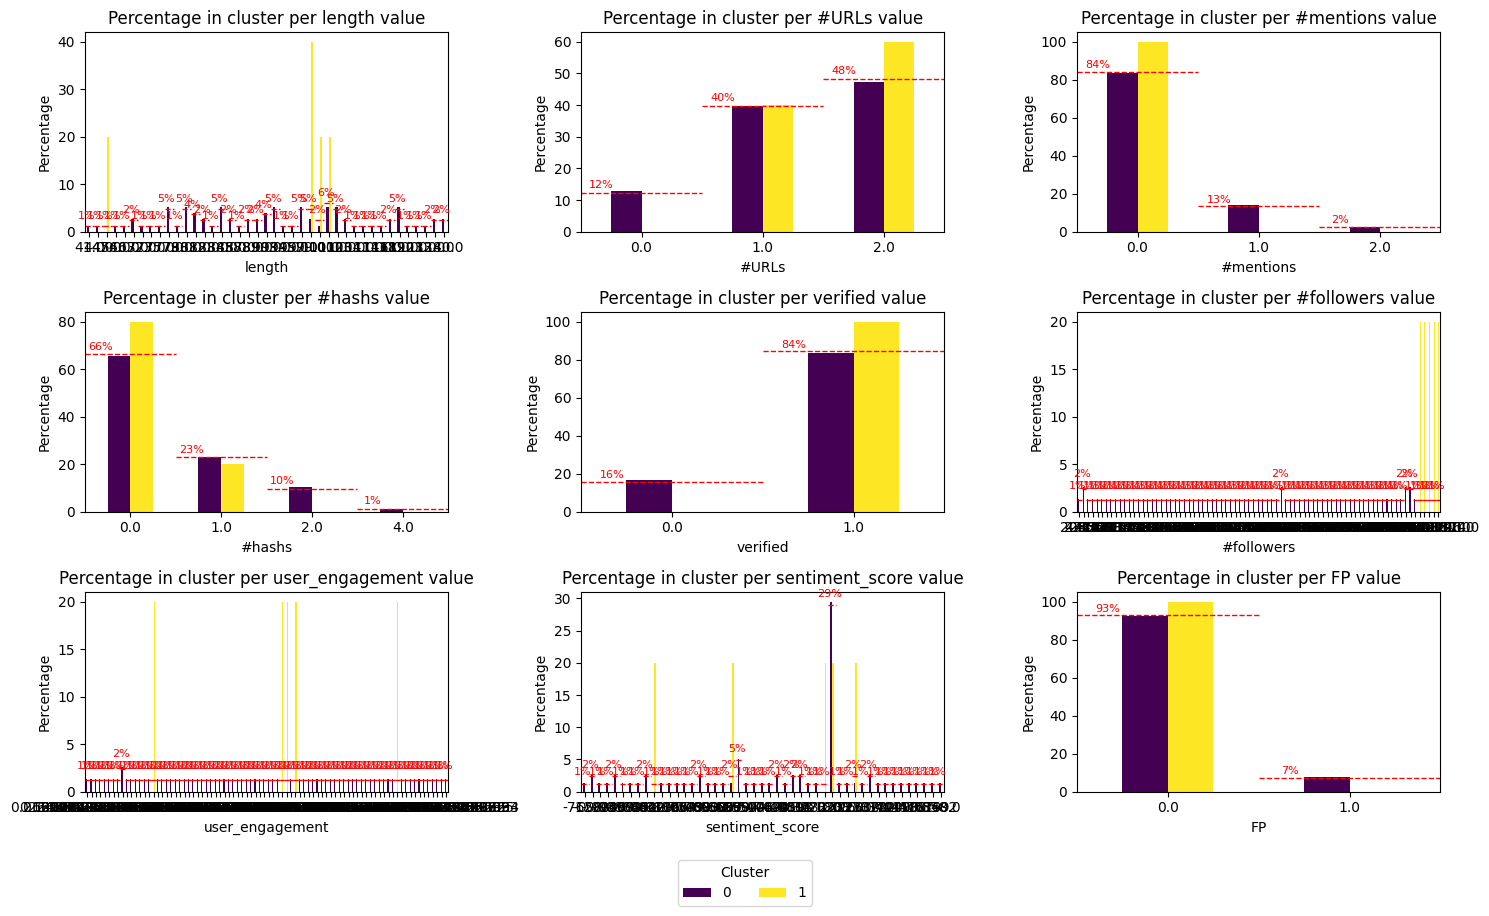

In [19]:
# Group by cluster_label and count the occurrences
cluster_counts = decoded_X_test["cluster_label"].value_counts()

# Create subplots for each column
columns_to_analyze = decoded_X_test.columns[:-1]  # Exclude 'cluster_label' column
rows = (len(columns_to_analyze) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, min(len(columns_to_analyze), 3), figsize=(15, 3 * rows), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, column in enumerate(columns_to_analyze):
    # Group by cluster_label and the column, then calculate percentages
    grouped_data = decoded_X_test.groupby(["cluster_label", column]).size().unstack(fill_value=0)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
    
    # Plot the percentage data without legend
    percentages.T.plot(kind="bar", ax=axes[i], colormap="viridis", legend=False)
    axes[i].set_title(f"Percentage in cluster per {column} value")
    axes[i].set_ylabel("Percentage")
    axes[i].set_xticklabels(percentages.T.index, rotation=0)
    
    # Calculate and plot the average percentage in the entire dataset for each category value
    overall_counts = decoded_X_test[column].value_counts(normalize=True) * 100
    for cat_value, avg_pct in overall_counts.items():
        # Find the x position for this category value
        try:
            x_pos = list(percentages.T.index).index(cat_value)
        except ValueError:
            continue  # skip if category not present in this cluster
        axes[i].axhline(y=avg_pct, xmin=x_pos / len(percentages.T.index), xmax=(x_pos + 1) / len(percentages.T.index),
                        linestyle='--', color='red', linewidth=1)
        axes[i].text(
            x=x_pos-0.33,
            y=avg_pct + 1,
            s=f"{avg_pct:.0f}%",
            color='red',
            fontsize=8,
            ha='center',
            va='bottom'
        )

# Adjust layout and show a single legend below the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.02), title='Cluster')
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [20]:
# Calculate the difference in percentage for each category value between cluster 0 and the entire dataset
diff_percentages = {}

# Select only cluster 0
cluster_0 = decoded_X_test[decoded_X_test["cluster_label"] == 0]

for column in decoded_X_test.columns:
    if column != "cluster_label":
        # Percentage in cluster 0
        cluster_0_pct = cluster_0[column].value_counts(normalize=True) * 100
        # Percentage in entire dataset
        overall_pct = decoded_X_test[column].value_counts(normalize=True) * 100
        # Align indexes and calculate difference
        diff = cluster_0_pct.subtract(overall_pct, fill_value=0)
        diff_percentages[column] = diff

# Add new columns to decoded_X_test for each category, showing the difference for cluster 0
for column, diff in diff_percentages.items():
    col_name = f"{column}_cluster0_diff_pct"
    # Map the difference only for cluster 0 rows, else set to NaN
    decoded_X_test[col_name] = decoded_X_test.apply(
        lambda row: diff.get(row[column], 0) if row["cluster_label"] == 0 else float('nan'),
        axis=1
    )

# print for cluster 0, per value of each category in columns of X_test, how much it appears more or less than average in that cluster
for column in X_test.columns:
    print(f"{column}")
    # Get the difference percentages for this column
    diff = diff_percentages.get(column)
    if diff is not None:
        for cat_value, pct_diff in diff.items():
            # only print if the difference between cluster and rest is dataset is larger than 2% 
            if pct_diff > 2:
                print(f"{cat_value}: {pct_diff:+.2f}% vs rest of dataset")

length
#URLs
#mentions
#hashs
verified
#followers
user_engagement
sentiment_score


In [21]:
# Calculate the difference in percentage for each category value between cluster 1 and the entire dataset (only for this notebook)
diff_percentages = {}

# Select only cluster 1
cluster_1 = decoded_X_test[decoded_X_test["cluster_label"] == 1]

for column in decoded_X_test.columns:
    if column != "cluster_label":
        # Percentage in cluster 1
        cluster_1_pct = cluster_1[column].value_counts(normalize=True) * 100
        # Percentage in entire dataset
        overall_pct = decoded_X_test[column].value_counts(normalize=True) * 100
        # Align indexes and calculate difference
        diff = cluster_1_pct.subtract(overall_pct, fill_value=0)
        diff_percentages[column] = diff

# Add new columns to decoded_X_test for each category, showing the difference for cluster 1
for column, diff in diff_percentages.items():
    col_name = f"{column}_cluster0_diff_pct"
    # Map the difference only for cluster 1 rows, else set to NaN
    decoded_X_test[col_name] = decoded_X_test.apply(
        lambda row: diff.get(row[column], 0) if row["cluster_label"] == 0 else float('nan'),
        axis=1
    )
    
# print for cluster 1, per value of each category in columns of X_test, how much it appears more or less than average in that cluster
for column in X_test.columns:
    print(f"{column}")
    # Get the difference percentages for this column
    diff = diff_percentages.get(column)
    if diff is not None:
        for cat_value, pct_diff in diff.items():
            # only print if the difference between cluster and rest is dataset is larger than 2% 
            if pct_diff > 2:
                print(f"{cat_value}: {pct_diff:+.2f}% vs rest of dataset")

length
47.0: +18.80% vs rest of dataset
99.0: +35.18% vs rest of dataset
100.0: +17.59% vs rest of dataset
101.0: +13.98% vs rest of dataset
#URLs
2.0: +11.81% vs rest of dataset
#mentions
0.0: +15.66% vs rest of dataset
#hashs
0.0: +13.73% vs rest of dataset
verified
1.0: +15.66% vs rest of dataset
#followers
27519418.0: +18.80% vs rest of dataset
46067494.0: +18.80% vs rest of dataset
46396851.0: +18.80% vs rest of dataset
54785196.0: +18.80% vs rest of dataset
57200174.0: +18.80% vs rest of dataset
user_engagement
13.942124105011931: +18.80% vs rest of dataset
58.81503006012024: +18.80% vs rest of dataset
58.97194388777555: +18.80% vs rest of dataset
61.56902761104442: +18.80% vs rest of dataset
157.71045918367346: +18.80% vs rest of dataset
sentiment_score
-0.8176: +18.80% vs rest of dataset
-0.5994: +17.59% vs rest of dataset
-0.1808: +18.80% vs rest of dataset
0.2732: +17.59% vs rest of dataset


#### G. Conclusion

**UI text #9**

From the above figures it can be observed what characteristics clusters have with statistically significant higher false positive rate (cluster 0 and 1).

In cluster 0:
- **age_cat**: 
    - 25 - 45: +8.29% vs rest of dataset
- **race**:
    - African-American: +8.20% vs rest of dataset
- **c_charge_degree**:
    - F: +10.67% vs rest of dataset
- **is_recid**:
    - 0: +5.80% vs rest of dataset

[only for this notebook]

In cluster 1:
- **age_cat**:
    - Less than 25: +58.63% vs rest of dataset
- **sex**:
    - Female: +3.19% vs rest of dataset
- **race**:
    - Caucasian: +36.80% vs rest of dataset
- **c_charge_degree**:
    - M: +31.88% vs rest of dataset
- **is_recid**:
    - 1: +46.99% vs rest of dataset
- **score_text**:
    - 1: +79.70% vs rest of dataset

Based on cluster 0, it can be concluded that `age_cat=25-45`, `race=African-American`, `c_charge_degree=F` and `is_recid=0` defendants  exhibit a high false positive rate, which is a known bias in the COMPAS dataset.

[only for this notebook]
Based on cluster 1, it can be concluded that `age_cat=Less than 25`, `sex=Female`, `race=Caucasian`, `c_charge_degree=M`, `is_recid=1` and `score_text=1` defendants  exhibit a high false positive rate, which is a known bias in the COMPAS dataset.